In [17]:
from model import *
from utils import *
from training import *
from data_processing import *

import importlib
import imports
importlib.reload(imports)

device = 'mps'
model_name = 'baseline'

# Enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
folder = os.getcwd()
filename = f'{folder}/ncmapps_ds02.csv'
print(filename)

/Users/alexei.ermochkine/Desktop/ma5/ML4PM/assignment_3_graded/ML4PM_assignment3/ncmapps_ds02.csv


In [19]:
df = pd.read_csv(filename)
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


In [20]:
LABELS = ['RUL']

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [21]:
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [22]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


In [23]:
# dataset parameters
TRAIN_UNITS = [2, 5, 10, 16, 18, 20]
TEST_UNITS = [11, 14, 15]

DEFAULT_PARAMS = {
    # CNN model parameters
    'in_channels': 18, 
    'out_channels': 1,
    'window': 50, 
    'n_ch': 10, 
    'n_k': 10, 
    'n_hidden': 50, 
    'n_layers': 3,
    'dropout': 0.,
    'padding': 'same',
    'use_batchnorm': False,
    # training parameters
    'batch_size': 256,  
    'base_lr': 1e-3,
    'weight_decay': 1e-5,
    'max_epochs': 50
}


DATASETS = create_datasets(df, window_size=DEFAULT_PARAMS['window'], train_units=TRAIN_UNITS, test_units=TEST_UNITS)
LOADERS = create_data_loaders(DATASETS, batch_size=DEFAULT_PARAMS['batch_size'], val_split=0.2)

train_size: 403236	validation_size: 100809	test_size: 115274


In [24]:
def run_single(seed, params=DEFAULT_PARAMS):
    seed_everything(seed)

    model = CNN(
        in_channels=params['in_channels'],
        out_channels=params['out_channels'], 
        n_ch=params['n_ch'],
        n_k=params['n_k'],
        n_hidden=params['n_hidden'],
        n_layers=params['n_layers'],
        dropout=params['dropout'],
        use_batchnorm=params['use_batchnorm'],
    ).to(device)  
    
    print(model)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['base_lr'],
        weight_decay=params['weight_decay'],
    )

    criterion = nn.MSELoss()
    trainer = Trainer(
        model,
        optimizer,
        criterion=criterion,
        n_epochs=params['max_epochs'],
        seed=seed,
        device=device,  # Pass device to trainer
        model_name=model_name,
    )

    trainer.fit(LOADERS)
    df_eval, df_eval_out = trainer.eval_rul_prediction(LOADERS[1])
    df_test, df_test_out = trainer.eval_rul_prediction(LOADERS[2])
    return df_eval, df_eval_out, df_test, df_test_out, trainer.losses4aggregation

## TRAINING ON 5 SEEDS
## reminder: CHANGE FOLDER AND MODEL_NAME IN TRAINING.PY BEFORE RUNNING !!!!!

In [25]:
SEED = 42
seed_everything(SEED)
device = 'mps'
N_RUNS = 5

df_list = []  
all_df_test = []
all_train_losses = []
all_eval_losses = []
all_test_losses = []

for seed in range(SEED, SEED+N_RUNS):
    print("--------------------- BEGGINING NEW SEED:", seed, "----------------")
    df_eval, df_eval_out, df_test, df_test_out, losses4aggregation = run_single(seed)
    all_train_losses.append(losses4aggregation['train'])
    all_eval_losses.append(losses4aggregation['eval'])
    all_test_losses.append(losses4aggregation['test'])
    all_df_test.append(df_test)
    df_list.append(df_test_out)  

df_all = pd.concat(df_list, ignore_index=True)  
all_train_losses = np.array(all_train_losses)
all_eval_losses = np.array(all_eval_losses)
all_test_losses = np.array(all_test_losses)

--------------------- BEGGINING NEW SEED: 42 ----------------
CNN(
  (conv_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Training model for 50 epochs...


/Users/alexei.ermochkine/Desktop/ma5/ML4PM/venv4ml4pm/lib/python3.12/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,


[Epoch 1] train_loss = 271.64627, eval_loss = 81.57659, test_loss = 182.69125 [21.4s]
[Epoch 2] train_loss = 90.06539, eval_loss = 76.01547, test_loss = 184.08185 [21.6s]
[Epoch 3] train_loss = 95.65839, eval_loss = 89.86785, test_loss = 219.46202 [20.6s]
[Epoch 4] train_loss = 99.87135, eval_loss = 56.23126, test_loss = 79.92881 [20.7s]
[Epoch 5] train_loss = 68.94144, eval_loss = 96.65948, test_loss = 70.63265 [20.8s]
[Epoch 6] train_loss = 75.94040, eval_loss = 54.84531, test_loss = 64.04855 [20.7s]
[Epoch 7] train_loss = 69.65076, eval_loss = 92.00981, test_loss = 103.81425 [21.1s]
[Epoch 8] train_loss = 67.34189, eval_loss = 51.13390, test_loss = 60.08730 [21.0s]
[Epoch 9] train_loss = 64.51634, eval_loss = 56.67287, test_loss = 76.56260 [22.2s]
[Epoch 10] train_loss = 62.61908, eval_loss = 78.66542, test_loss = 83.80703 [19.9s]
[Epoch 11] train_loss = 59.30732, eval_loss = 143.77837, test_loss = 341.10718 [22.1s]
[Epoch 12] train_loss = 61.13586, eval_loss = 158.91815, test_loss 

/Users/alexei.ermochkine/Desktop/ma5/ML4PM/assignment_3_graded/ML4PM_assignment3/training.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

[Epoch 50] train_loss = 47.57318, eval_loss = 39.83934, test_loss = 82.78238 [20.4s]
Task done in 1064s
Evaluating test RUL...
Model CNN saved in models_baseline/baseline_1106112319.pt loaded to mps


100%|██████████| 394/394 [00:02<00:00, 156.53it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/baseline_1106112319.pt loaded to mps


100%|██████████| 451/451 [00:02<00:00, 196.93it/s]


--------------------- BEGGINING NEW SEED: 43 ----------------
CNN(
  (conv_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Training model for 50 epochs...
[Epoch 1] train_loss = 287.92291, eval_loss = 80.28056, test_loss = 142.26106 [20.3s]
[Epoch 2] train_loss = 99.50390, eval_loss = 212.93240, test_loss = 160.95007 [20.3s]
[Epoch 3] train_loss = 90.06439, eval_loss = 102.69146, test_loss = 245.88927 [20.3s]
[Epoch 4] train_loss = 80.32040, eval_loss = 58.74809, test_loss = 127.22639 [20.2s]
[Epoch 5] train_loss = 78.21342, eval_loss = 112.93199, 

100%|██████████| 394/394 [00:02<00:00, 140.91it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/baseline_1106114108.pt loaded to mps


100%|██████████| 451/451 [00:02<00:00, 169.71it/s]


--------------------- BEGGINING NEW SEED: 44 ----------------
CNN(
  (conv_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Training model for 50 epochs...
[Epoch 1] train_loss = 274.07425, eval_loss = 88.40753, test_loss = 72.18822 [22.3s]
[Epoch 2] train_loss = 167.29810, eval_loss = 100.89509, test_loss = 73.95718 [23.9s]
[Epoch 3] train_loss = 93.51512, eval_loss = 110.84829, test_loss = 80.54584 [22.1s]
[Epoch 4] train_loss = 95.78902, eval_loss = 57.72613, test_loss = 63.43248 [21.6s]
[Epoch 5] train_loss = 85.48563, eval_loss = 97.49954, test

100%|██████████| 394/394 [00:02<00:00, 155.63it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/baseline_1106115904.pt loaded to mps


100%|██████████| 451/451 [00:02<00:00, 191.97it/s]


--------------------- BEGGINING NEW SEED: 45 ----------------
CNN(
  (conv_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Training model for 50 epochs...
[Epoch 1] train_loss = 271.60730, eval_loss = 113.97140, test_loss = 83.78598 [25.6s]
[Epoch 2] train_loss = 91.67934, eval_loss = 68.01817, test_loss = 146.93925 [24.1s]
[Epoch 3] train_loss = 81.73988, eval_loss = 72.99405, test_loss = 155.80351 [24.8s]
[Epoch 4] train_loss = 76.45898, eval_loss = 53.40998, test_loss = 62.63831 [23.2s]
[Epoch 5] train_loss = 72.29668, eval_loss = 58.51379, test

100%|██████████| 394/394 [00:02<00:00, 161.28it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/baseline_1106121711.pt loaded to mps


100%|██████████| 451/451 [00:02<00:00, 198.94it/s]


--------------------- BEGGINING NEW SEED: 46 ----------------
CNN(
  (conv_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Training model for 50 epochs...
[Epoch 1] train_loss = 276.03192, eval_loss = 106.15920, test_loss = 84.13374 [25.6s]
[Epoch 2] train_loss = 106.23490, eval_loss = 73.72554, test_loss = 112.56352 [22.2s]
[Epoch 3] train_loss = 93.33399, eval_loss = 116.67912, test_loss = 268.70078 [23.2s]
[Epoch 4] train_loss = 83.38728, eval_loss = 74.34775, test_loss = 72.53048 [23.7s]
[Epoch 5] train_loss = 87.47788, eval_loss = 85.68494, te

100%|██████████| 394/394 [00:02<00:00, 132.39it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/baseline_1106123453.pt loaded to mps


100%|██████████| 451/451 [00:02<00:00, 164.46it/s]


# PLOTTING RESULTS

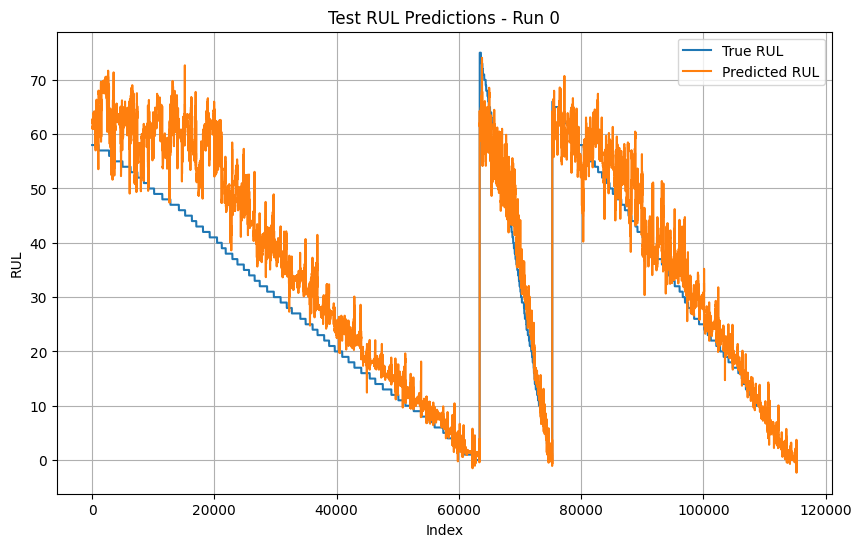

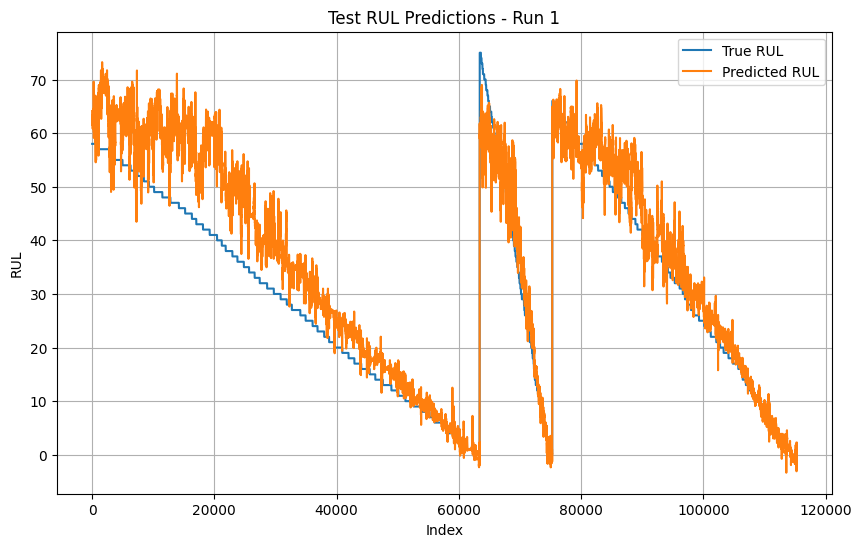

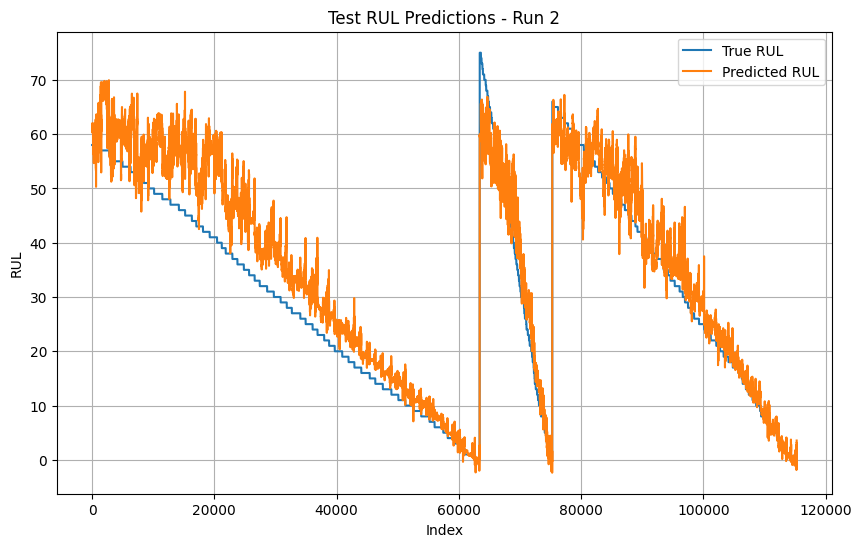

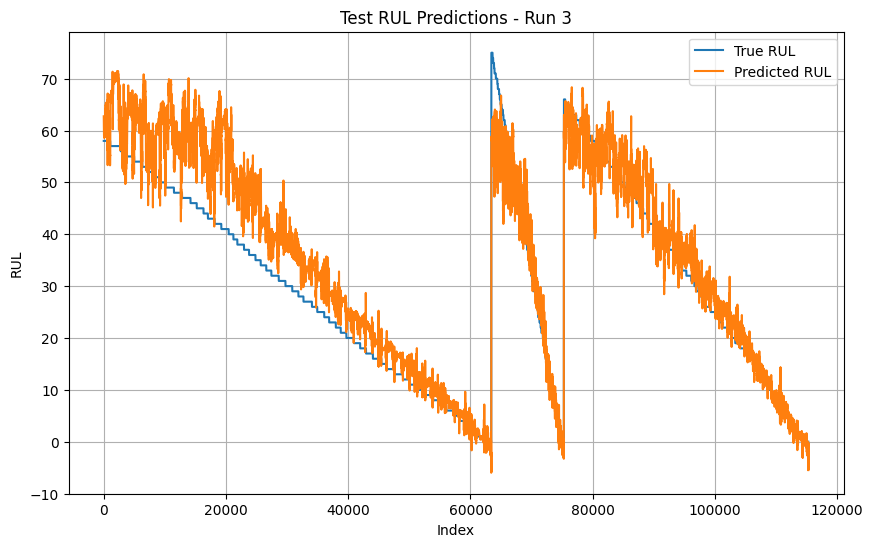

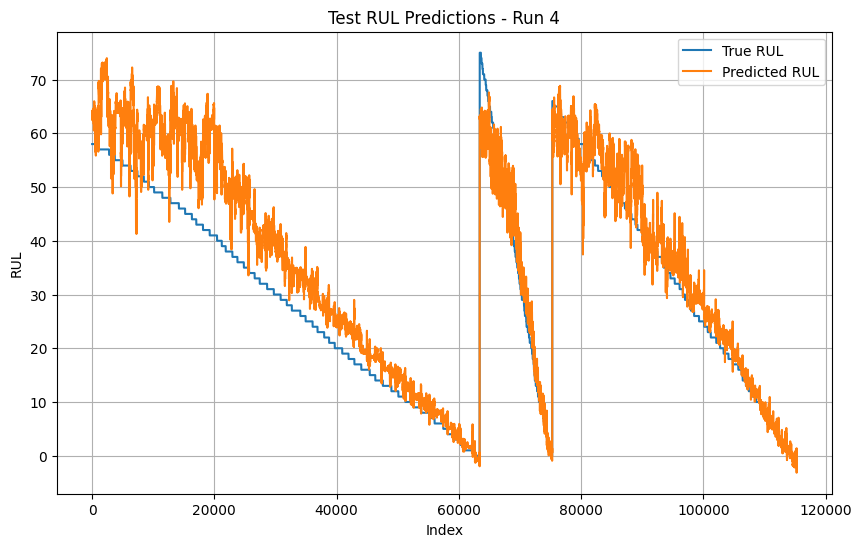

In [ ]:
plot_test_rul_predictions(all_df_test, df_all, model_name, save=True, show=True)


In [ ]:
plot_smoothed_rul_predictions(all_df_test, df_all, model_name, smoothing_window=50, save=True, show=True)

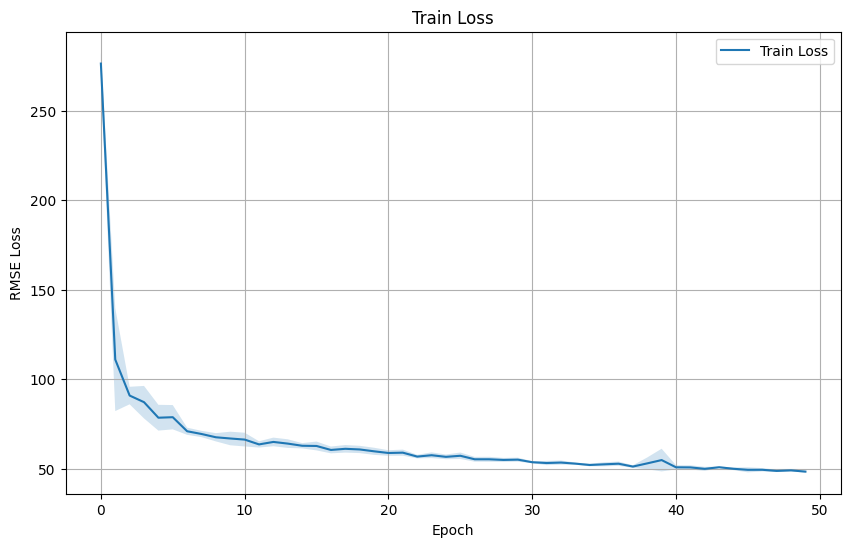

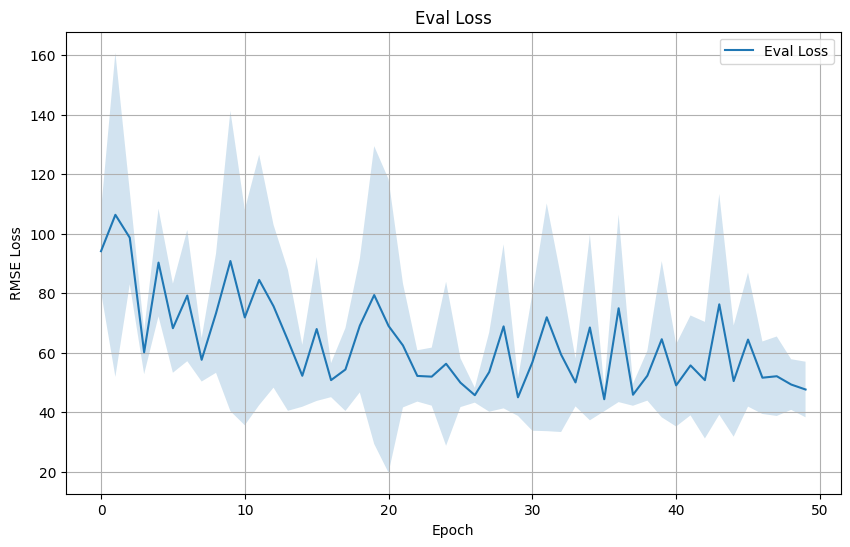

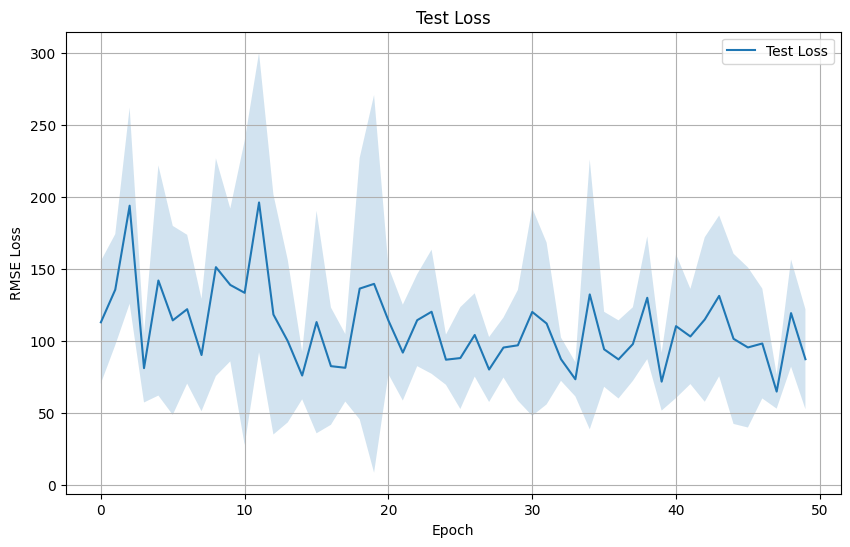

In [27]:

# Plot the aggregated losses
plot_aggregated_losses(all_train_losses, all_eval_losses, all_test_losses, model_name, save=True, show=True)


In [28]:
df_all.to_csv(f'test_scores/{model_name}_df_all.csv', index=False)
df_all.head()


,score,rmse,seed
0,2.265049,7.241673,42
1,2.302963,7.441130,43
2,2.052249,6.404578,44
3,2.154943,6.910720,45
4,2.304267,7.416053,46
